## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


ALS – это прежде всего коллаборативная фильтрация, а item-item - content-based детерминированный алгоритм.
Мы проговаривали это на уроке: для ALS важен факт взаимодействия с товаром, услугой или чем-то еще, что мы рекомендуем. В Item-item это в явном виде может и не быть.  
ALS использует эмбеддинги данных о пользователе и товаре. В рекомендациях item-item используется информация о товаре и подбирается исходя из сходства пользователей и товаров

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


-	оценки товаров, выставляемые пользователями 
-	количество комментариев 
-	репост о товаре в фейсбуке, инстаграме и т.д
-	отзыв о товаре с оценкой

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


- по типу информации на входе: только факт взаимодействия (обсуждали на семинаре) 
- линейна относительно факторов 
- отсутствие персонализации (как гипотеза – является ли?) 
- не учитывает влияние нестационарных составляющих временного ряда
- однородность и качество входных данных
- имеет одинаковые веса ошибок предсказаний.


4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

https://ru.wikipedia.org/wiki/Okapi_BM25

Как это работает расписано в статье на хабре: 
https://habr.com/ru/post/162937/
Там же есть ссылка на документ с расчетом bm25.

## Практическая часть


In [19]:
import implicit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
import os, sys
from implicit.evaluation import precision_at_k
import warnings

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from time import time

warnings.filterwarnings('ignore')

In [2]:
def precision_at_k(recommended_list, bought_list, k=8):
    if type(bought_list) == str:
        bought_str_list = bought_list[1:-1].split(', ')
        bought_list = [int(item) for item in bought_str_list]

    if type(recommended_list) == str:
        bought_str_list = recommended_list[1:-1].split(', ')
        recommended_list = [int(item) for item in bought_str_list]

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)

    return precision

In [25]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]

    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)

    return precision

In [4]:
data = pd.read_csv('retail_train.csv')

test_size_weeks = 3
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [8]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [10]:
result = pd.read_csv('preds.csv')
result.head()

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[12301743, 1197499, 13158155, 12777288, 1090812]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[926554, 596117, 6551663, 2072973, 929091]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[12386107, 1051460, 1122611, 10457243, 6553593]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 878996]","[999999, 1082185, 1029743, 6534178, 1127831]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1029621, 1134688, 832873, 995840, 300134]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 999999, 1127831, 961554]","[1082185, 981760, 1127831, 999999, 961554]","[999999, 1082185, 1029743, 1127831, 995785]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[9396767, 918534, 9525708, 1010504, 13038933]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 1098066]","[1082185, 981760, 999999, 1098066, 826249]","[1082185, 981760, 999999, 1098066, 826249]","[999999, 1082185, 1029743, 1098066, 6534178]"


In [15]:
result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [11]:
def get_matrix(values):

    # матрица весов
    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values=values, 
                                      aggfunc= 'count', 
                                      fill_value=0)

    user_item_matrix = user_item_matrix.astype(float)

    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))

    return user_item_matrix, userid_to_id, id_to_itemid, itemid_to_id, sparse_user_item

In [12]:
def get_model(user_item_matrix, factors, regularization):
        
    model = AlternatingLeastSquares(factors=factors,
                                        regularization=regularization,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
    
    return model

In [13]:
def get_recommendations(user, model, user_item_matrix, userid_to_id, id_to_itemid, itemid_to_id, sparse_user_item):
    
    recs = model.recommend(userid=userid_to_id[user],
                                user_items=sparse_user_item, 
                                N=5,
                                filter_already_liked_items=False, 
                                filter_items=[itemid_to_id[999999]],#None, 
                                recalculate_user=True)

    res = [id_to_itemid[rec[0]] for rec in recs]

    return res

In [16]:
%%time
       
stata_v = pd.DataFrame(columns=['values', 'result_train', 'result_test'])

values = ['quantity', 'day', 'trans_time', 'store_id']

for i, v in enumerate(values):
    
    ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui = get_matrix(v)
    model_als = get_model(ui_matrix, factors=100, regularization=0.001)

    result_train['als_'+v] = result_train['user_id'].apply(lambda x: \
                            get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
    r_train = result_train.apply(lambda row: precision_at_k(row['als_'+v], row['actual']), axis=1).mean()
    
    result_test['als_'+v] = result_test['user_id'].apply(lambda x: \
                            get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
    r_test= result_test.apply(lambda row: precision_at_k(row['als_'+v], row['actual']), axis=1).mean()

    stata_v.loc[i] = [v, r_train, r_test]
    
stata_v

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 4min 52s


,values,result_train,result_test
0,quantity,0.828171,0.181293
1,day,0.828331,0.181587
2,trans_time,0.828331,0.179824
3,store_id,0.827691,0.182566


**Видим, что сильных отличий в результатах нет, требуется дальнейшая обработка данных, чтобы получить пользу от различия весов разных матриц.**

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [6]:
items = pd.read_csv('product.csv')
items.columns = [col.lower() for col in items.columns]
items.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [7]:
items.rename(columns={'product_id': 'item_id'}, inplace=True)
items.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [25]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]

    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)

    return precision

In [30]:
factors=[30, 50, 70]
regularization = [0.1, 0.01, 0.001]

v = 'day'
ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui = get_matrix(v)

stata_g = pd.DataFrame(columns=['factor', 'regular', 'time', 'result_train', 'result_test'])

for i in factors:
    for j in regularization:
        time_start = time()
        model_als = get_model(ui_matrix, factors=i, regularization=j)
        time_finish = time() - time_start
        
        result_train[f'als_f_{i}_r_{j}'] = result_train['user_id'].apply(lambda x: \
                                get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
        r_train = result_train.apply(lambda row: precision_at_k(row[f'als_f_{i}_r_{j}'], row['actual']), axis=1).mean()
        
        result_test[f'als_f_{i}_r_{j}'] = result_test['user_id'].apply(lambda x: \
                                get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
        r_test= result_test.apply(lambda row: precision_at_k(row[f'als_f_{i}_r_{j}'], row['actual']), axis=1).mean()

        stata_g.loc[f'{i}_{j}'] = [i, j, time_finish, r_train, r_test]
        
stata_g

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,factor,regular,time,result_train,result_test
30_0.1,30.0,0.100,2.566111,0.667467,0.187561
30_0.01,30.0,0.010,2.699169,0.664266,0.186582
30_0.001,30.0,0.001,2.594066,0.669068,0.185406
50_0.1,50.0,0.100,2.622987,0.715326,0.188247
50_0.01,50.0,0.010,2.579108,0.716206,0.188541
50_0.001,50.0,0.001,2.576636,0.715566,0.183741
70_0.1,70.0,0.100,2.801513,0.754942,0.184329
70_0.01,70.0,0.010,2.736683,0.754462,0.182860
70_0.001,70.0,0.001,2.756634,0.758303,0.186092


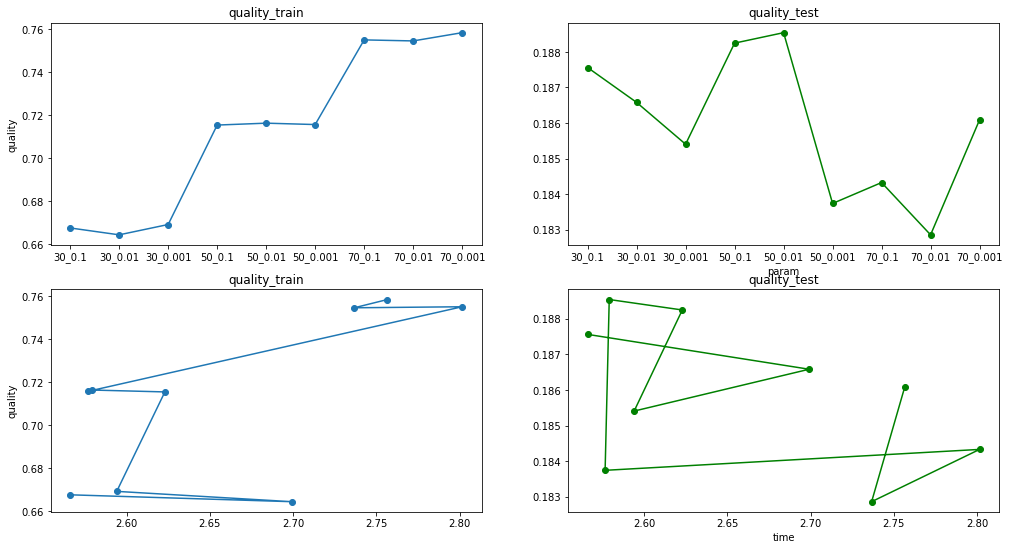

In [32]:
x1 = np.array(stata_g['time'])
x2 = np.array(stata_g.index)

y1 = np.array(stata_g['result_train'])
y2 = np.array(stata_g['result_test'])

plt.figure(figsize=(17, 9))

plt.subplot(2, 2, 1)
plt.plot(x2, y1)
plt.scatter(x2, y1)
plt.title('quality_train')
plt.ylabel('quality')

plt.subplot(2, 2, 2)
plt.plot(x2, y2, c='g')
plt.scatter(x2, y2, c='g')
plt.title('quality_test')
plt.xlabel('param')

plt.subplot(2, 2, 3)
plt.plot(x1, y1)
plt.scatter(x1, y1)
plt.title('quality_train')
plt.ylabel('quality')

plt.subplot(2, 2, 4)
plt.plot(x1, y2, c='g')
plt.scatter(x1, y2, c='g')
plt.title('quality_test')
plt.xlabel('time')

plt.show()

### Выводы:
* чем больше времени занимает обучение модели, тем выше качетво прогнозирования на train, но качество прогнозирования на test нестабилен.
* при увеличении гиперпараметра factors и уменьшении regularization качество на train растет, в то время как качество на test падает или также нестабилен.
* оптимальные параметры для модели AlternatingLeastSquares на текущих данных:
    * factors=50
    * regularization=0.01